In [ ]:
from google.colab import files
import logging
files.upload()  # Upload kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')         # Add path to drive 

Mounted at /content/drive


In [ ]:
import sys

In [ ]:
!pip install kagglehub
!pip install polars
# For the VQAEvaluator
!pip install cairosvg
!pip install -U bitsandbytes
!pip install lxml
# For the QAGenerator
!pip install -q sentencepiece
# For the Aesthetic
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
# Generating QA questions and answers
from utils.model_qaGenerator import QAGenerator
qa_generator = QAGenerator()

In [ ]:
# Generating QA questions and answers
import polars as pl
import pandas as pd
import ast
import logging
import copy
import pdb

train = pd.read_csv('/content/drive/MyDrive/drawing-with-llms/train.csv')
logging.getLogger("utils.model_qaGenerator").setLevel(logging.INFO)
total_table = []

for index, row in train.iterrows():
  row_dict = row.to_dict()
  description = row_dict['description']
  print(description)
  solution = qa_generator.generate(description)
  total_table.append({'id':'abcde',
                      'description':row['description'],
                      'question': solution.iloc[0]['question'],
                      'choices': solution.iloc[0]['choices'],
                      'answer': solution.iloc[0]['answer']
                      })
total_table = pd.DataFrame(total_table)

path = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/total_table.csv'
total_table.to_csv(path, index=False)

qa_generator.unload()


In [ ]:
# Generating SVG images
from utils.model_svgGenerator import SVGGenerator
from utils.constraints_file import enforce_constraints
import logging
svg_generator = SVGGenerator()

In [ ]:
# Generating SVG images
import pandas as pd

path = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/total_table.csv'
total_table = pd.read_csv(path)
new_rows = []

for index, row in total_table.iterrows():
  row_dict = row.to_dict()
  print(f"Index: {index}, Description: {row_dict['description']}")
  row_dict['svg'] = enforce_constraints(svg_generator.predict(row_dict['description']))
  new_rows.append(row_dict)

total_table = pd.DataFrame(new_rows)
total_table.to_csv(path, index=False)

svg_generator.unload()

In [ ]:
# Scoring Aesthetic
from utils.model_Aesthetic import AestheticEvaluator
aesthetic_evaluator = AestheticEvaluator()

In [ ]:
# Scoring Aesthetic
import pandas as pd
from PIL import Image
from IPython.display import Image as DisplayImage, display
import cairosvg

path = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/total_table.csv'
path_image = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/output.png'
total_table = pd.read_csv(path)
new_rows = []

for index, row in total_table.iterrows():
  row_dict = row.to_dict()
  print(f"Index: {index}, Description: {row_dict['description']}")
  cairosvg.svg2png(bytestring=row_dict['svg'].encode('utf-8'), write_to=path_image)
  pil_image = Image.open(path_image)
  row_dict['aesthetic_score'] = aesthetic_evaluator.score(pil_image)
  new_rows.append(row_dict)

total_table = pd.DataFrame(new_rows)
total_table.to_csv(path, index=False)

aesthetic_evaluator.unload()

In [ ]:
# Scoring VQAevaluator
from utils.model_vqaEvaluatior import VQAEvaluator
from utils.image_processor import ImageProcessor
vqa_evaluator = VQAEvaluator()

In [ ]:
# Scoring VQAevaluator
import pandas as pd
from PIL import Image
from IPython.display import Image as DisplayImage, display
import cairosvg
import copy
import pdb

path = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/total_table.csv'
path_image = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/output.png'
total_table = pd.read_csv(path)
new_rows = []

for index, row in total_table.iterrows():
  row_dict = row.to_dict()
  print(f"Index: {index}, Description: {row_dict['description']}")
  cairosvg.svg2png(bytestring=row_dict['svg'].encode('utf-8'), write_to=path_image)
  pil_image = Image.open(path_image).convert('RGB')
  image_processor = ImageProcessor(pil_image).apply()
  df = pd.DataFrame({'id': [row_dict['id']],
                     'question': [row_dict['question']],
                     'choices': [row_dict['choices']],
                     'answer': [row_dict['answer']]
                    })
  row_dict['vqa_score'] = vqa_evaluator.score(df, image_processor.image)
  new_rows.append(row_dict)

total_table = pd.DataFrame(new_rows)
total_table.to_csv(path, index=False)

vqa_evaluator.unload()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import cairosvg
import textwrap


path_image = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/output.png'

def svg2pil(svg):
  cairosvg.svg2png(bytestring=svg.encode('utf-8'), write_to=path_image)
  pil_image = Image.open(path_image).convert('RGB')
  return pil_image

rows, cols = 15, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
last_r = cols -1

axes[0, last_r].set_title('gemma-2-9b-it', fontsize=12, pad=25)

for index, row in total_table.iterrows():
  ax = axes[index, 0]
  ax.axis('off')  # Hide axis ticks and labels
  long_text = total_table.iloc[index]['description']
  wrapped_text = textwrap.fill(long_text, width=20)
  ax.text(0.5, 0.5, wrapped_text, fontsize=12, ha='center', va='center')

  ax = axes[index, 1]
  ax.axis('off')  # Hide axis ticks and labels
  long_text = total_table.iloc[index]['question']
  wrapped_text = textwrap.fill(long_text, width=45)
  ax.text(0, 0.5, wrapped_text, fontsize=6, ha='left', va='center')

  ax = axes[index, 2]
  ax.axis('off')  # Hide axis ticks and labels
  long_text = total_table.iloc[index]['answer']
  wrapped_text = textwrap.fill(long_text, width=30)
  ax.text(0, 0.5, wrapped_text, fontsize=6, ha='left', va='center')

  ax = axes[index, last_r]
  ax.imshow(svg2pil(total_table.iloc[index]['svg']))
  ax.text(
      0, -10,                # X center, Y above image (Y < 0 means "above")
      f" vqa: {total_table.iloc[index]['vqa_score']:.{2}f},  aes: {total_table.iloc[index]['aesthetic_score']:.{2}f}",
      fontsize=10,
      color='black',
      ha='left',
      va='bottom'
  )
  ax.axis('off')

# # Adjust layout to avoid overlap
# plt.tight_layout(pad=0.0)  # Increase padding between elements
# plt.show()

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import Image as DisplayImage, display, SVG
import matplotlib.pyplot as plt
from PIL import Image as ImagePil
from huggingface_hub import login
import cairosvg
from utils.constraints_file import enforce_constraints
import re

login(token="my_token")             # Add hugging face token

# model_id = "sd-legacy/stable-diffusion-v1-5"
model_id = "Fictiverse/Stable_Diffusion_PaperCut_Model"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")



In [ ]:
path_sour = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/'
# prompt = "a lighthouse overlooking the ocean, in flat vector style, svg illustration, simple clean shapes"
prompt = "a purple forest at dusk"
prompt = prompt + " svg style,  flat colors, no gradients"

image = pipe(prompt).images[0]

image.save(path_sour + 'output.png')

png_to_svg_with_colors(path_sour + "output.png", path_sour + "output.svg", n_colors=10)
cairosvg.svg2png(url = path_sour + 'output.svg', write_to= path_sour + 'output2.png')

with open(path_sour + "output.svg", "r", encoding="utf-8") as f:
    svg_string = f.read()
match_questions = re.findall(r"<svg\s*(.*?)\s*/></svg>", svg_string, re.DOTALL)
match_questions = '<svg ' + match_questions[0] + ' /></svg>'
enforced = enforce_constraints(match_questions)
cairosvg.svg2png(bytestring=enforced.encode('utf-8'), write_to= path_sour + 'output3.png')

rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
ax = axes[0]
ax.axis('off')
ax.imshow(ImagePil.open((path_sour + 'output.png')))
ax = axes[1]
ax.imshow(ImagePil.open((path_sour + 'output2.png')))
ax.axis('off')
ax = axes[2]
ax.imshow(ImagePil.open((path_sour + 'output3.png')))
ax.axis('off')


In [ ]:
import utils.constraints_file
import importlib
importlib.reload(utils.constraints_file)
from utils.constraints_file import enforce_constraints
import re

path_sour = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/'


logging.getLogger("utils.constraints_file").setLevel(logging.DEBUG)

with open(path_sour + "output.svg", "r", encoding="utf-8") as f:
    svg_string = f.read()
match_questions = re.findall(r"<svg\s*(.*?)\s*/></svg>", svg_string, re.DOTALL)
match_questions = '<svg ' + match_questions[0] + ' /></svg>'
enforced = enforce_constraints(match_questions)
cairosvg.svg2png(bytestring=enforced.encode('utf-8'), write_to= path_sour + 'output3.png')

rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
ax = axes[0]
ax.axis('off')
ax.imshow(ImagePil.open((path_sour + 'output.png')))
ax = axes[1]
ax.imshow(ImagePil.open((path_sour + 'output2.png')))
ax.axis('off')
ax = axes[2]
ax.imshow(ImagePil.open((path_sour + 'output3.png')))
ax.axis('off')


In [ ]:
# Install dependencies for stable diffusion model
!pip install diffusers
!pip install cairosvg
!pip install opencv-python svgwrite pillow

removed region: 104035.0


<ipython-input-4-d1fb37bd929f>:85: RuntimeWarning: invalid value encountered in arccos
  deg = np.degrees(np.arccos(u_v/(u_u*v_v)))


removed region: 0.0
Total Areas: 53025
Total Areas after: 28025
The size is 298518


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

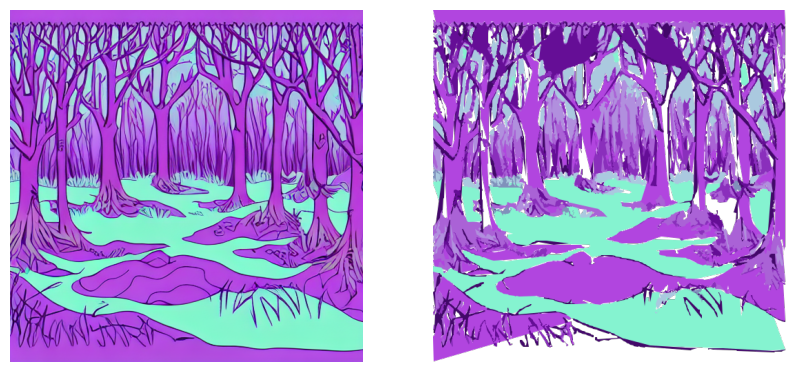

In [ ]:
path_sour = '/content/drive/MyDrive/drawing-with-llms/drawing_project/assets/'
import cairosvg
import matplotlib.pyplot as plt
from PIL import Image as ImagePil
import re


areas = png_to_svg_with_colors(path_sour + "output.png",  "output_t.svg", n_colors=10, min_area=100, slice_d = 1, deg_thress=20)

# print(areas)

with open("output_t.svg", "r", encoding="utf-8") as f:
    svg_string = f.read()
match_questions = re.findall(r"<svg\s*(.*?)\s*/></svg>", svg_string, re.DOTALL)
match_questions = '<svg ' + match_questions[0] + ' /></svg>'

print(f"The size is {len(match_questions.encode('utf-8'))}")

cairosvg.svg2png(url = 'output_t.svg', write_to= 'output_t.png')
rows, cols = 1, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
ax = axes[0]
ax.axis('off')
ax.imshow(ImagePil.open((path_sour + 'output.png')))
ax = axes[1]
ax.imshow(ImagePil.open(('output_t.png')))
ax.axis('off')



In [ ]:
# Compress SVG image algorithm version 1
import cv2
import numpy as np
import svgwrite
from PIL import Image
from sklearn.cluster import KMeans
import pdb

def quantize_image(image, n_colors=8):
    """Reduce number of colors in the image for cleaner vectorization."""
    data = image.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=n_colors, n_init='auto')
    labels = kmeans.fit_predict(data)
    palette = kmeans.cluster_centers_.astype(np.uint8)
    quantized = palette[labels].reshape(image.shape)
    return quantized, labels.reshape(image.shape[:2]), palette

def trace_regions_by_color(image, labels, palette, output_svg, min_area, slice_d, deg_thress):
    height, width = image.shape[:2]
    dwg = svgwrite.Drawing(output_svg, size=(width, height))
    areas = 0
    areas_t = 0

    masked_image = np.zeros((height, width), dtype=np.uint8)
    for i, color in enumerate(palette):
        # Mask for current color

        mask = (labels == i).astype(np.uint8) * 255
        kernel = np.ones((2, 2), np.uint8)

        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hex_color = svgwrite.utils.rgb(color[0], color[1], color[2])

        for contour in contours:
          area = cv2.contourArea(contour)
          if area<min_area:
            continue

          points = [(pt[0][0], pt[0][1]) for pt in contour]

          curated_points = [points[0]]
          last_point = points[0]
          cummulative_deg = 0
          for i in range(len(points)-2):
            u_v = (points[i+1][0] - last_point[0])*(points[i+2][0] - last_point[0]) + (points[i+1][1] - last_point[1])*(points[i+2][1] - last_point[1])
            u_u = ((points[i+1][0] - last_point[0])**2 + (points[i+1][1] - last_point[1])**2)**(1/2)
            v_v = ((points[i+2][0] - last_point[0])**2 + (points[i+2][1] - last_point[1])**2)**(1/2)

            areas_t += 1

            if abs(u_u*v_v) < 1e-9:
              continue
            deg = np.degrees(np.arccos(u_v/(u_u*v_v)))
            cummulative_deg += deg
            if abs(deg)>deg_thress or abs(cummulative_deg)>deg_thress:
              # print('here')
              areas += 1
              curated_points.append(points[i+1])
              last_point = points[i+1]
              cummulative_deg = 0
          curated_points.append(points[len(points)-1])
          # curated_points = points
          # path_data = "M " + " L ".join([f"{x},{y}" for x, y in points[::slice_d]]) + " Z"
          path_data = "M " + " L ".join([f"{x},{y}" for x, y in curated_points]) + " Z"
          dwg.add(dwg.path(d=path_data, fill=hex_color, stroke='none'))

    dwg.save()
    print(f"Total Areas: {areas_t}")
    print(f"Total Areas after: {areas}")
    return areas

def png_to_svg_with_colors(input_path, output_path, n_colors=8, min_area=400, slice_d=1, deg_thress=10):
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    quantized, labels, palette = quantize_image(image, n_colors)
    areas = trace_regions_by_color(image, labels, palette, output_path, min_area, slice_d, deg_thress)
    return areas

In [ ]:
# Compress SVG image algorithm version 2

import cv2
import numpy as np
import svgwrite
from PIL import Image
from sklearn.cluster import KMeans
import pdb

def quantize_image(image, n_colors=8):
    """Reduce number of colors in the image for cleaner vectorization."""
    data = image.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=n_colors, n_init='auto')
    labels = kmeans.fit_predict(data)
    palette = kmeans.cluster_centers_.astype(np.uint8)
    quantized = palette[labels].reshape(image.shape)
    return quantized, labels.reshape(image.shape[:2]), palette

def trace_regions_by_color(image, labels, palette, output_svg, min_area, slice_d, deg_thress):
    height, width = image.shape[:2]
    dwg = svgwrite.Drawing(output_svg, size=(width, height))
    areas = 0
    areas_t = 0

    mask_remove_regions = np.zeros((height, width), dtype=np.uint8)

    for i, color in enumerate(palette):
        # Mask for current color

        mask = (labels == i).astype(np.uint8) * 255

        kernel = np.ones((2, 2), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
          area = cv2.contourArea(contour)
          if area<min_area:
            mask_t = np.zeros((height, width), dtype=np.uint8)
            cv2.drawContours(mask_t, [contour], contourIdx=-1, color=255, thickness=cv2.FILLED)
            mask_remove_regions = cv2.bitwise_or(mask_remove_regions, mask_t)

    print(f"removed region: {np.sum(mask_remove_regions)/255}")

    for i, color in enumerate(palette):
        # Mask for current color

        mask = (labels == i).astype(np.uint8) * 255

        kernel = np.ones((3, 3), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)

        new_region = cv2.bitwise_and(dilated_mask, mask_remove_regions)
        # print(f"before -> Mask: {i}, size: {np.sum(mask)/255}")
        # print(f"before -> Maks: {i}, region added: {np.sum(new_region)/255}")
        mask = cv2.bitwise_or(mask, new_region)
        mask_remove_regions = cv2.subtract(mask_remove_regions, new_region)

        # print(f"Mask: {i}, size: {np.sum(mask)/255}")
        # print(f"removed region: {np.sum(mask_remove_regions)/255}")

        kernel = np.ones((2, 2), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        hex_color = svgwrite.utils.rgb(color[0], color[1], color[2])

        for contour in contours:
          area = cv2.contourArea(contour)
          if area<min_area:
            continue
          # print(f"Area: {area} ")
          points = [(pt[0][0], pt[0][1]) for pt in contour]

          curated_points = [points[0]]
          last_point = points[0]
          cummulative_deg = 0
          for i in range(len(points)-2):
            u_v = (points[i+1][0] - last_point[0])*(points[i+2][0] - last_point[0]) + (points[i+1][1] - last_point[1])*(points[i+2][1] - last_point[1])
            u_u = ((points[i+1][0] - last_point[0])**2 + (points[i+1][1] - last_point[1])**2)**(1/2)
            v_v = ((points[i+2][0] - last_point[0])**2 + (points[i+2][1] - last_point[1])**2)**(1/2)

            areas_t += 1

            if abs(u_u*v_v) < 1e-9:
              continue
            deg = np.degrees(np.arccos(u_v/(u_u*v_v)))
            cummulative_deg += deg
            if abs(deg)>deg_thress or abs(cummulative_deg)>deg_thress:
              # print('here')
              areas += 1
              curated_points.append(points[i+1])
              last_point = points[i+1]
              cummulative_deg = 0
          curated_points.append(points[len(points)-1])
          # curated_points = points
          # path_data = "M " + " L ".join([f"{x},{y}" for x, y in points[::slice_d]]) + " Z"
          path_data = "M " + " L ".join([f"{x},{y}" for x, y in curated_points]) + " Z"
          dwg.add(dwg.path(d=path_data, fill=hex_color, stroke='none'))

    print(f"removed region: {np.sum(mask_remove_regions)/255}")

    dwg.save()
    print(f"Total Areas: {areas_t}")
    print(f"Total Areas after: {areas}")
    return areas

def png_to_svg_with_colors(input_path, output_path, n_colors=8, min_area=400, slice_d=1, deg_thress=10):
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    quantized, labels, palette = quantize_image(image, n_colors)
    areas = trace_regions_by_color(image, labels, palette, output_path, min_area, slice_d, deg_thress)
    return areas